In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from IPython.display import Image


from PIL import Image
import skimage 

#dataloader

class HRFDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):
    # Resize

        imageTransform= transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])

        maskTransform= transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])

        image= imageTransform(image)
        mask= maskTransform(mask)

        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y
    def __len__(self):
    
        return len(self.image_paths)




In [0]:
# Creating training paths for dataset
extra_val="0"
train_dir="/content/drive/My Drive/retinanet/dataset/images/"
mask_dir="/content/drive/My Drive/retinanet/dataset/mask/"
train_array=[]
val_array=[]
for i in range(1,12):
    if(i<10):
        train_array.append(train_dir+extra_val+str(i)+"_dr.JPG")
        train_array.append(train_dir+extra_val+str(i)+"_g.jpg")
        train_array.append(train_dir+extra_val+str(i)+"_h.jpg")
    else:
        train_array.append(train_dir+str(i)+"_dr.JPG")
        train_array.append(train_dir+str(i)+"_g.jpg")
        train_array.append(train_dir+str(i)+"_h.jpg")

for i in range(1,12):
    if(i<10):
        val_array.append(mask_dir+extra_val+str(i)+"_dr_mask.tif")
        val_array.append(mask_dir+extra_val+str(i)+"_g_mask.tif")
        val_array.append(mask_dir+extra_val+str(i)+"_h_mask.tif")
    else:
        val_array.append(mask_dir+str(i)+"_dr_mask.tif")
        val_array.append(mask_dir+str(i)+"_g_mask.tif")
        val_array.append(mask_dir+str(i)+"_h_mask.tif")

# Creating Validation paths dataset



valid_image=[]
valid_mask=[]
for i in range(12,16):
    if(i<10):
        valid_image.append(train_dir+extra_val+str(i)+"_dr.JPG")
        valid_image.append(train_dir+extra_val+str(i)+"_g.jpg")
        valid_image.append(train_dir+extra_val+str(i)+"_h.jpg")
    else:
        valid_image.append(train_dir+str(i)+"_dr.JPG")
        valid_image.append(train_dir+str(i)+"_g.jpg")
        valid_image.append(train_dir+str(i)+"_h.jpg")

for i in range(12,16):
    if(i<10):
        valid_mask.append(mask_dir+extra_val+str(i)+"_dr_mask.tif")
        valid_mask.append(mask_dir+extra_val+str(i)+"_g_mask.tif")
        valid_mask.append(mask_dir+extra_val+str(i)+"_h_mask.tif")
    else:
        valid_mask.append(mask_dir+str(i)+"_dr_mask.tif")
        valid_mask.append(mask_dir+str(i)+"_g_mask.tif")
        valid_mask.append(mask_dir+str(i)+"_h_mask.tif")

train_set= HRFDataset(train_array,val_array)
val_set= HRFDataset(valid_image,valid_mask)

print train_set.image_paths



['/content/drive/My Drive/retinanet/dataset/images/01_dr.JPG', '/content/drive/My Drive/retinanet/dataset/images/01_g.jpg', '/content/drive/My Drive/retinanet/dataset/images/01_h.jpg', '/content/drive/My Drive/retinanet/dataset/images/02_dr.JPG', '/content/drive/My Drive/retinanet/dataset/images/02_g.jpg', '/content/drive/My Drive/retinanet/dataset/images/02_h.jpg', '/content/drive/My Drive/retinanet/dataset/images/03_dr.JPG', '/content/drive/My Drive/retinanet/dataset/images/03_g.jpg', '/content/drive/My Drive/retinanet/dataset/images/03_h.jpg', '/content/drive/My Drive/retinanet/dataset/images/04_dr.JPG', '/content/drive/My Drive/retinanet/dataset/images/04_g.jpg', '/content/drive/My Drive/retinanet/dataset/images/04_h.jpg', '/content/drive/My Drive/retinanet/dataset/images/05_dr.JPG', '/content/drive/My Drive/retinanet/dataset/images/05_g.jpg', '/content/drive/My Drive/retinanet/dataset/images/05_h.jpg', '/content/drive/My Drive/retinanet/dataset/images/06_dr.JPG', '/content/drive/M

In [0]:
from torch.utils.data import Dataset, DataLoader

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 10

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}


dataset_sizes = {
    x: len(image_datasets[x].image_paths) for x in image_datasets.keys()
}

dataset_sizes

{'train': 33, 'val': 12}

In [0]:
from torchvision import models

base_model = models.resnet18(pretrained=True)
    


In [0]:

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)



In [0]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


  
  
  
class ResNetUNet(nn.Module):
  
    def up(self,prev_features, layer, layer_conv, up_conv):

      layer=layer_conv(layer)
      prev_features=torch.cat([prev_features,layer],dim=1)
      prev_features=up_conv(prev_features)
      return self.upsample(prev_features)

    def __init__(self, n_class):
        super(ResNetUNet,self).__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        # Transfer Learning. Reusing Resnet Base Model Layers
        self.layer0 = nn.Sequential(*self.base_layers[:3]) 
        self.layer0_conv = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])        
        self.layer1_conv = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]         
        self.layer2_conv = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]        
        self.layer3_conv = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7] 
        self.layer4_conv = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Upconv Layers
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        
        
        #base model layers
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        #uping
        
        layer4 = self.layer4_conv(layer4)
        x = self.upsample(layer4)
        x = self.up(x,layer3,self.layer3_conv,self.conv_up3)
        x = self.up(x,layer2, self.layer2_conv, self.conv_up2)
        x = self.up(x, layer1, self.layer1_conv, self.conv_up1)    
        x = self.up(x, layer0, self.layer0_conv, self.conv_up0) 
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [0]:

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(1)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import torch
 


def save_epoch_loss(loss, label, phase, lossMem):
  lossMem['loss'+phase]+=loss.data.cpu().numpy()* label.size(0)


def train_model(mode,optimizer,scheduler,num_epochs=15):
  best_weights=copy.deepcopy(model.state_dict())
  best_loss=1e10
  for epoch in range(num_epochs):
    print "EPOCH"
    print '{}/{}'.format(epoch,num_epochs-1)
    
    ## training the model
    scheduler.step()
    model.train() #setting training mode on
    lossMem = defaultdict(float)
    
    for inputs,labels in dataloaders['train']:
      inputs = inputs.to(device)
      labels= labels.to(device)
      
      optimizer.zero_grad()
      with torch.set_grad_enabled(True): 
        outputs = model(inputs)

        outputsFlat=outputs.view(-1)
        labelsFlat= labels.view(-1)
        
        loss = F.binary_cross_entropy_with_logits(outputsFlat, labelsFlat)
        save_epoch_loss(loss,labels,'train', lossMem)
        
        loss.backward()
        optimizer.step()
    epoch_loss= lossMem['losstrain']/10
        
        ## validation phase

    if epoch_loss<best_loss:
      print("saving best model")
      best_loss = epoch_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print "Training Loss: {}".format(lossMem['losstrain'])
    print "-"*10

  print('Final val loss: {:4f}'.format(best_loss))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return mode

In [0]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = ResNetUNet(num_class).to(device)

# Freezing Backbone Layers
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-55)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

cuda:0
EPOCH
0/14
saving best model
Training Loss: 27.6502408385
----------
EPOCH
1/14
Training Loss: 27.6505297422
----------
EPOCH
2/14
saving best model
Training Loss: 27.6497926116
----------
EPOCH
3/14
Training Loss: 27.6503124237
----------
EPOCH
4/14
Training Loss: 27.6503201127
----------
EPOCH
5/14
saving best model
Training Loss: 27.6496711373
----------
EPOCH
6/14
Training Loss: 27.6526566744
----------
EPOCH
7/14
Training Loss: 27.650824368
----------
EPOCH
8/14
Training Loss: 27.6499474049
----------
EPOCH
9/14
Training Loss: 27.6517448425
----------
EPOCH
10/14
saving best model
Training Loss: 27.6492168903
----------
EPOCH
11/14
Training Loss: 27.6492430568
----------
EPOCH
12/14
Training Loss: 27.6507505178
----------
EPOCH
13/14
Training Loss: 27.6511119008
----------
EPOCH
14/14
Training Loss: 27.6507943273
----------
Final val loss: 2.764922


(10, 1, 224, 224)


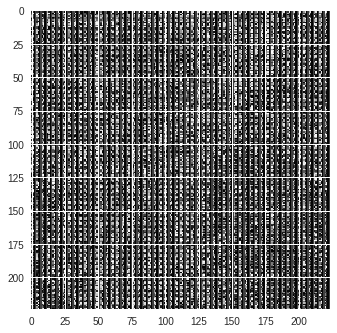

In [0]:
#### prediction

import math
from PIL import Image
import matplotlib.pyplot as plt
model.eval()   # Set model to evaluate mode


inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

for i in range(10):
  for x in pred[i]:
    img = Image.fromarray(x , 'L')
    plt.imshow(img)